In [1]:
# just execute this cell to have the proper functions imported
# the cell must run correctly to be able to run the assignement
#
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
from scipy import __version__ as scipy_version
answers = {}

## Black-Scholes Model Setup: 


### **Black-Scholes SDE (Modeling Stock Prices)**
The Black-Scholes model assumes that the price $ S_t $ of a risky asset (e.g., a stock) follows a **geometric Brownian motion**:

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t,
$$

where:
- $ \mu $ = drift (expected return),
- $ \sigma $ = volatility,
- $ W_t $ = standard Brownian motion.

This SDE implies:
- Stock prices are log-normally distributed.
- Returns are normally distributed with constant volatility $ \sigma $.

---

### **Black-Scholes Formula (Option Pricing)**
The Black-Scholes formula calculates the price of a **European call/put option** under the assumption of no arbitrage and perfect hedging. For a call option with strike $ K $ and maturity $ T $:

$$
C(S_t, t) = S_t \Phi(d_1) - Ke^{-r(T-t)} \Phi(d_2),
$$

where:
- $ r $ = risk-free rate,
- $ \Phi $ = standard normal CDF,
- $ d_1 = \frac{\ln(S_t/K) + (r + \sigma^2/2)(T-t)}{\sigma \sqrt{T-t}} $,
- $ d_2 = d_1 - \sigma \sqrt{T-t} $.

The put price $ P $ is obtained via **put-call parity**.

---


## **Principal Protected Note (PPN) with Participation Rate $ \mathrm{PR} $ and Strike $ K $**

#### **Overview**
A PPN guarantees the return of the investor’s principal (initial investment) at maturity, regardless of the underlying asset’s performance, while offering partial participation in the upside of the asset above a strike price $ K $. The participation rate $ PR $ (where $ 0 < PR \leq 1 $) determines how much of the upside the investor receives.

#### **Payoff Formula**
Assuming:
- $ P $: Principal amount (initial investment).
- $ S_0 $: Initial value of the underlying asset.
- $ S_T $: Terminal value of the underlying asset at maturity.
- $ K $: Strike price (reference level for participation).
- $ \mathrm{PR} $: Participation rate (fraction of the upside gained).

The payoff at maturity is:
$$
\text{Payoff} = P + P \cdot \mathrm{PR} \cdot \max\left(\frac{S_T - K}{S_0}, 0\right)
$$

#### **Breakdown**
1. **Principal Protection**: The investor always receives at least $ P $ back at maturity, even if $ S_T < K $.
2. **Upside Participation**: If $ S_T > K $, the investor earns a fraction $ PR $ of the return above $ K $, scaled relative to $ S_0 $ (initial asset value).
   - Return above strike: $ \frac{S_T - K}{S_0} $ (percentage gain relative to initial value).
   - Participation: $ PR \cdot \max\left(\frac{S_T - K}{S_0}, 0\right) $.
3. **No Downside Risk**: If $ S_T \leq K $, the payoff is simply $ P $.

#### **Example**
- $ P = 1000 $, $ S_0 = 100 $, $ K = 100 $, $ PR = 0.8 $, $ T = 1 $ year.
- Case 1: $ S_T = 120 $
  - $ \frac{S_T - K}{S_0} = \frac{120 - 100}{100} = 0.2 $
  - Payoff = $ 1000 + 1000 \cdot 0.8 \cdot 0.2 = 1000 + 160 = 1160 $.
- Case 2: $ S_T = 90 $
  - $ \frac{S_T - K}{S_0} = \frac{90 - 100}{100} = -0.1 $, so $ \max(-0.1, 0) = 0 $
  - Payoff = $ 1000 + 1000 \cdot 0.8 \cdot 0 = 1000 $.

#### **Characteristics**
- **Upside**: Limited by $ \mathrm{PR} < 1 $ (e.g., 80% of gains).
- **Downside**: Fully protected (payoff never below $ P $).
- Often funded by the issuer using the interest that would have been earned on $ P $ in a risk-free investment, with the remainder used to buy call options.

---


### **Pricing**  
| Parameter          | Example Value       |  
|--------------------|---------------------|  
| **Term**      | $T=1$       |  
| **Rate** | $r=5\%$    |  
| **Volatility** | $\sigma=20\%$    |  
| **Spot** | $S_0=100$    |  
| **Strike** | $K=100$    |  


In [2]:
def black_scholes_price(S, K, T, r, sigma, is_call):
    if T < 1e-8 or sigma<1e-8:
        return max(S - K, 0)  if is_call else max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if is_call:
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)    
    return price
    
S0,T,r,sigma,K = 100,1,0.05,0.2,100
df   = np.exp(-r*T)
call = black_scholes_price(S0, K, T, r, sigma, is_call=True)/S0
PR   = ( 1 - df ) / call # <--- edit this line with proper calculation
print(df,call,PR)
answers["PPN: discount factor is"] = df
answers["PPN: call price is"]      = call
answers["PPN: PR (assuming no issue cost)"] = PR

0.951229424500714 0.10450583572185565 0.46667801049014945


### **Equity-Linked Note (ELN) with Strike $ K $**

#### **Overview**
An ELN is a debt instrument where the payoff is linked to the performance of an underlying equity asset. Unlike a PPN, an ELN does not guarantee principal protection and typically resembles a combination of a bond and a short put option (or sometimes a call option structure). The payoff depends on whether $ S_T $ is above or below the strike $ K $, and it often includes a fixed coupon or principal repayment modified by equity performance.

#### **Payoff Formula**
A common ELN structure is a **reverse convertible ELN** (short put-like):
- $ P $: Principal amount (initial investment).
- $ S_T $: Terminal value of the underlying asset.
- $ K $: Strike price (barrier or conversion level).
- $ C $: Coupon payment (fixed or zero, depending on structure).

The payoff at maturity is:
$$
\text{Payoff} =
\begin{cases} 
P + C & \text{if } S_T \geq K \text{ (underlying performs well, principal returned plus coupon)} \\
P \cdot \frac{S_T}{K} + C & \text{if } S_T < K \text{ (underlying underperforms, physical delivery or scaled principal)}
\end{cases}
$$

Alternatively, some ELNs deliver shares if $ S_T < K $:
$$
\text{Payoff} =
\begin{cases} 
P + C & \text{if } S_T \geq K \\
\frac{P}{K} \cdot S_T + C & \text{if } S_T < K \text{ (equivalent to delivering } \frac{P}{K} \text{ shares valued at } S_T\text{)}
\end{cases}
$$

#### **Breakdown**
1. **Above Strike ($ S_T \geq K $)**: Investor receives the principal $ P $ plus any coupon $ C $, similar to a bond.
2. **Below Strike ($ S_T < K $)**: Investor receives a reduced payoff proportional to $ S_T / K $, effectively bearing downside risk as if they sold a put option.
   - This mimics delivering $ \frac{P}{K} $ shares of the underlying, valued at $ S_T $.
3. **Coupon**: $ C $ may be zero or a fixed amount, often higher than a standard bond to compensate for downside risk.

#### **Example**
- $ P = 1000 $, $ K = 100 $, $ C = 50 $ (5% coupon), $ S_0 = 100 $.
- Case 1: $ S_T = 110 $
  - $ S_T \geq K $, so Payoff = $ 1000 + 50 = 1050 $.
- Case 2: $ S_T = 80 $
  - $ S_T < K $, so Payoff = $ 1000 \cdot \frac{80}{100} + 50 = 800 + 50 = 850 $.

#### **Characteristics**
- **Upside**: Limited to $ P + C $ (no participation in gains above $ K $).
- **Downside**: Exposed to losses if $ S_T < K $, proportional to the drop.
- Often structured as the issuer selling a put option to the investor, with the premium funding the coupon.

---


In [3]:
T,K = 0.5, 0.70*S0 # <- we assume a 6m maturity and 70% strike
df  = np.exp(-r*T)
put = black_scholes_price(S0, K, T, r, sigma, is_call=False)/S0
C   = 0 # <--- edit this line with proper calculation
print(df, put, C)
answers["ELN: discount factor is"] = df
answers["ELN: put price is"]       = put
answers["ELN: coupon C (assuming no issue cost)"] = C

0.9753099120283326 0.00012407926560673854 0


## Simulated Brownian Motion

We simulate $N_{sim}xN_T$ iid gaussian variables $G_{ij} \sim N(0,\sqrt{\delta t})$. 

The brownian motions for sample $\omega_i$ at time $t_j$ is given by
$$
W_{t_j}(\omega_i) = \sum_{i=1}^{j} G_{ij}
$$

| Parameter          | Example Value       |  
|--------------------|---------------------|  
| **simulations**      | $N_{sim}=10000$       |  
| **time steps** | $N_T=20$    |  


check time step: 0.025 0.025


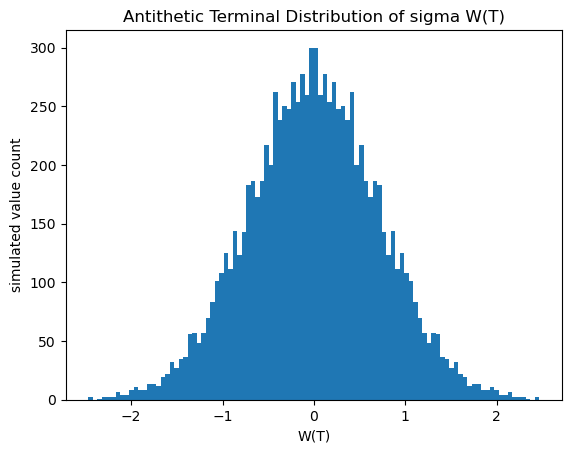

E(WT)=5.329070518200751e-19, std(WT)/sigma.sqrt(T)=1.0139147145929448


In [6]:
def checkterminalbrownian(Wt):
    WT  = Wt[:,-1]
    plt.hist(WT,bins=100)
    plt.xlabel("W(T)")
    plt.ylabel("simulated value count")
    plt.title("Antithetic Terminal Distribution of sigma W(T)")
    plt.show()
    print(f"E(WT)={np.mean(WT)}, std(WT)/sigma.sqrt(T)={np.std(WT)/(np.sqrt(T))}")

nsim,nT = 10000,20
deltat  = T/nT
t       = np.linspace(0,T,nT+1)[1:]
print("check time step:",t[1]-t[0], deltat)
np.random.seed(42)
Z   = np.random.normal(loc=0, scale=np.sqrt(deltat), size=(nsim//2, nT))
dWt = np.vstack([Z,-Z]) # antithetic sampling
Wt  = np.cumsum(dWt,axis=1)
checkterminalbrownian(Wt)
answers["antithetic sampling std(WT)"] = np.std(Wt) # <- put the standard deviation of W_T

## Simulated Stock Price

In the **Black-Scholes framework**, the stock price \( S_t \) follows **geometric Brownian motion (GBM)**, and its solution is given by:

$$
S_t = S_0 \exp\left( \left( r - \frac{1}{2} \sigma^2 \right) t + \sigma W_t \right)
$$

### **Key Components Explained**
1. **$ r $ (Risk-Free Rate)**  
   - Represents the **expected return** in a risk-neutral world.  
   - Ensures the discounted stock price is a martingale (no arbitrage).  

2. **$ -\frac{1}{2} \sigma^2 t $ (Itô Correction Term)**  
   - Adjusts for the **convexity effect** of the exponential function.  
   - Comes from **Itô’s Lemma**: Applying calculus to stochastic processes requires this term to preserve the martingale property.  

3. **$ \sigma W_t $ (Volatility-Driven Randomness)**  
   - $ W_t \sim \mathcal{N}(0, t) $ is a **Brownian motion** (Wiener process).  
   - Introduces log-normal distributed returns: $ \ln(S_t/S_0) \sim \mathcal{N}\left( (r - \frac{1}{2} \sigma^2)t, \sigma^2 t \right) $.  

### **Why This Form?**
- **Log-Normal Prices**: Ensures $ S_t > 0 $.  
- **Martingale Property**: Under the risk-neutral measure $ \mathbb{Q} $, $ e^{-rt} S_t $ has no drift.  
- **Matches Black-Scholes PDE**: Derived from hedging arguments.  

### **Simplified Intuition**
- **Expected return** is $ r $ (discounting), but **variance drag** ($ -\frac{1}{2} \sigma^2 $) offsets the geometric growth.  
- **Random shocks** scale with $ \sigma \sqrt{t} $.  



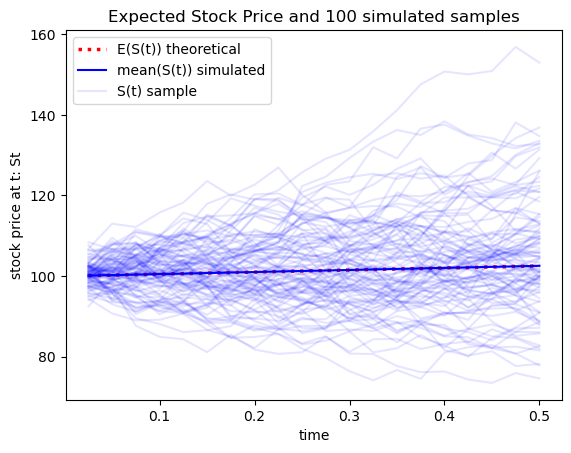

102.38670043782646


In [12]:
St = S0*np.exp(r*t-.5*sigma**2*t+sigma*Wt)
plt.plot(t,S0*np.exp(r*t),label="E(S(t)) theoretical",color="red",linestyle=":",linewidth=2.5)
plt.plot(t,np.mean(St,axis=0),label="mean(S(t)) simulated",color="blue")
ttl = 0
for i in range(100):
    ttl += St[i,11]
    plt.plot(t,St[i,:],color="blue",alpha=0.1,label="S(t) sample" if i==0 else None)
plt.title("Expected Stock Price and 100 simulated samples")
plt.legend()
plt.xlabel("time")
plt.ylabel("stock price at t: St")
plt.show()
print(ttl/100)
answers["antithetic sampling: avg(S(t=0.35)"] = ttl/100 # <- edit this line with MC estimate of S_t for t=0.35
answers["antithetic sampling: E(S(t=0.35)"] = 100 # <- edit this line with exact estimate of S_t for t=0.35

## Payoff: accumulator

### **Accumulator Payoff Description**
An accumulator is a derivative contract where the buyer agrees to purchase a fixed number of shares (or units) of an underlying asset (e.g., a stock or index) at a predetermined **strike price (K)** over a series of settlement periods (e.g., daily, weekly, or monthly) until maturity or an early termination event. It typically includes a **knock-out price (KO)** that ends the contract if the asset price exceeds this level. The payoff depends on the asset’s price behavior relative to the strike and knock-out levels.

#### **Payoff Mechanics**
1. **Accumulation Phase (Asset Price < KO):**
   - For each settlement period, the buyer accumulates a fixed number of shares at the strike price \(K\).
   - **Per-period payoff** = (Market Price at Settlement - \(K\)) × Number of Shares Accumulated.
     - If the market price > \(K\), the buyer gains by accumulating shares at a discount.
     - If the market price < \(K\), the buyer incurs a loss, as they pay more than the market value.
   - Some contracts double the accumulation rate (e.g., 2x shares) if the price falls below \(K\), amplifying losses.

2. **Knock-Out Event (Asset Price ≥ KO):**
   - If the asset price hits or exceeds the knock-out price on an observation date, the contract terminates early.
   - **Total payoff** = (Market Price at Knock-Out - \(K\)) × Total Shares Accumulated up to that point.
   - The buyer receives all shares accumulated so far, and no further accumulation occurs.

3. **Maturity (No Knock-Out):**
   - If the contract runs to maturity without hitting the knock-out price, the buyer accumulates shares across all periods.
   - **Total payoff** = $\sum$ (Market Price at Each Settlement - $K$) × Shares per Period.
   - The final value depends on the market price path over the contract term.

#### **Example**
- **Parameters:** Strike \(K = 100\), Knock-Out \(KO = 120\), 1 share accumulated daily, 20-day term, initial price = 105.
- **Scenario 1: Moderate Rise**
  - Day 1: Price = 106, Payoff = (106 - 100) × 1 = 6.
  - Day 5: Price = 121, Knock-Out triggered.
  - Total Payoff = (Sum of daily gains/losses for 4 days) + (121 - 100) × 5 shares = depends on prior days + 105.
- **Scenario 2: Decline**
  - Day 20: Price = 90, no knock-out.
  - Daily Payoff = (90 - 100) × 1 = -10 per day.
  - Total Payoff = -10 × 20 = -200.

#### **Key Characteristics**
- **Upside:** Limited to gains from buying at \(K\) below market price, capped by the knock-out.
- **Downside:** Potentially unlimited, as the buyer must keep buying at \(K\) even if the asset price collapses.
- **Risk Profile:** Often described as “I kill you later” due to the accumulating losses in a falling market.



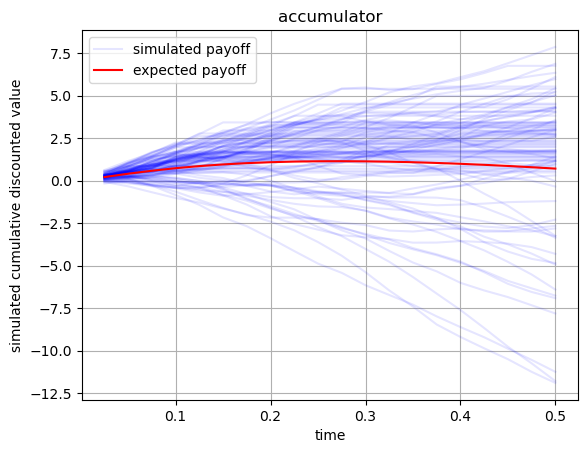

premium=0.70%


In [14]:
def calc_survival_indicator(kill_condition):
    """Calculate survival indicator: 1 if path is active, 0 if knocked out."""
    first_knockout_idx = np.argmax(kill_condition, axis=1)  # Index of first barrier hit per path
    never_knocked_out = ~np.any(kill_condition, axis=1)     # Paths that never hit barrier
    first_knockout_idx[never_knocked_out] = kill_condition.shape[1]  # Set to nT if no knockout
    time_steps = np.arange(kill_condition.shape[1])[np.newaxis, :]   # Shape (1, nT)
    survival_indicator = (time_steps < first_knockout_idx[:, np.newaxis]).astype(int)  # 1 until knockout
    return survival_indicator

K  = 96
KO = 110
sharesperperiod = deltat/T #  contract is scaled to buy at most one stock over time T
knockoutsurv    = calc_survival_indicator(St>KO)
accumulated = (St-K)*sharesperperiod 
discount    = np.exp(-r*t)
cumulativevalue = np.cumsum(accumulated*knockoutsurv*discount,axis=1)
cumulpvbyt      = np.mean(cumulativevalue,axis=0)
for i in range(100):
    plt.plot(t,cumulativevalue[i,:],label="simulated payoff" if i==0 else None, color="blue",alpha=0.1)
plt.plot(t,cumulpvbyt,label="expected payoff",color="red")
plt.grid(True)
plt.legend()
plt.title("accumulator")
plt.xlabel("time")
plt.ylabel("simulated cumulative discounted value")
plt.show()
print("premium={:.2f}%".format(cumulpvbyt[-1]*100/S0))
answers["accumulator: most simulations result in positive outcome"] = "yes" # <- edit
answers["accumulator: negative scenario result in much lower outcome"] = "yes" # <- edit

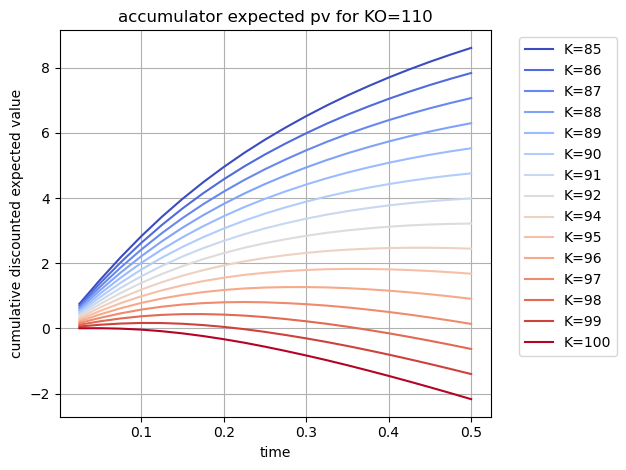

In [15]:
nk=15
colors = plt.cm.coolwarm(np.linspace(0, 1, nk))
for i,k in enumerate(np.linspace(85,100,nk)):
    accumulated = (St-k)*sharesperperiod
    cumulativevalue = np.cumsum(accumulated*knockoutsurv*discount,axis=1)
    cumulpvbyt      = np.mean(cumulativevalue,axis=0)
    plt.plot(t,cumulpvbyt,label="K=%.0f" % k,color=colors[i])
#plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.title("accumulator expected pv for KO=%.0f" % KO)
plt.xlabel("time")
plt.ylabel("cumulative discounted expected value")
plt.tight_layout()
plt.show()
answers["accumulator: expected pv increase with accumulation strike"] = "no" # <- edit
answers["accumulator: fait buy strike for KO=100 is"] = 110 # <- edit

### Accumulator with leverage 


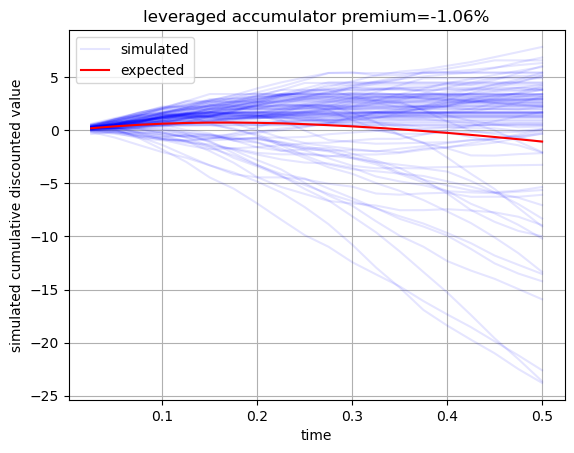

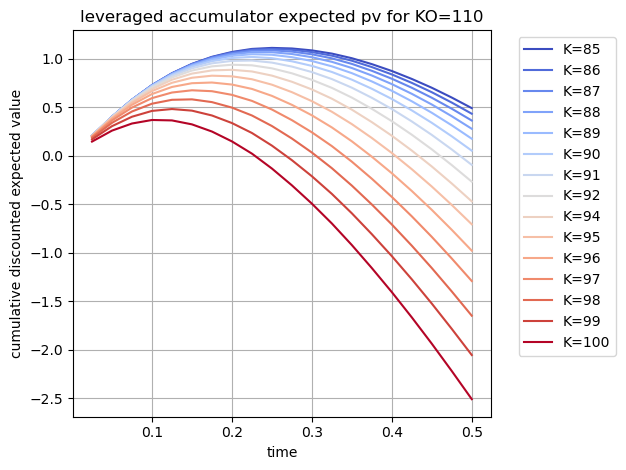

In [16]:
K  = 96
KO = 110
sharesperperiod = deltat/T #  contract is scaled to buy at most one stock over time T
knockoutsurv    = calc_survival_indicator(St>KO)
accumulated = ((St-K)+np.minimum(0,St-K))*sharesperperiod 
discount    = np.exp(-r*t)
cumulativevalue = np.cumsum(accumulated*knockoutsurv*discount,axis=1)
cumulpvbyt      = np.mean(cumulativevalue,axis=0)
for i in range(100):
    plt.plot(t,cumulativevalue[i,:],label="simulated" if i==0 else None, color="blue",alpha=0.1)
plt.plot(t,cumulpvbyt,label="expected",color="red")
plt.grid(True)
plt.legend()
plt.title("leveraged accumulator premium={:.2f}%".format(cumulpvbyt[-1]*100/S0))
plt.xlabel("time")
plt.ylabel("simulated cumulative discounted value")
plt.show()
nk=15
colors = plt.cm.coolwarm(np.linspace(0, 1, nk))
for i,k in enumerate(np.linspace(85,100,nk)):
    accumulated = ((St-K)+np.minimum(0,St-k))*sharesperperiod 
    cumulativevalue = np.cumsum(accumulated*knockoutsurv*discount,axis=1)
    cumulpvbyt      = np.mean(cumulativevalue,axis=0)
    plt.plot(t,cumulpvbyt,label="K=%.0f" % k,color=colors[i])
#plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.title("leveraged accumulator expected pv for KO=%.0f" % KO)
plt.xlabel("time")
plt.ylabel("cumulative discounted expected value")
plt.tight_layout()
plt.show()
answers["having 2x leveraged accumulation below K changes the positive scenarios"] = "yes/no" # <- edit
answers["having 2x leveraged accumulation makes adverse scenarios x times worse"] = 0 # <- enter x
answers["having 2x leveraged accumulation leads to a fair strike far below 85"] = "yes/no" # <- enter x
answers["having 2x leveraged accumulation leads to a fair strike far above 100"] = "yes/no" # <- enter x

## Payoff Autocall

### **Autocallable Structured Product ("Autocall") - Overview**  
An **autocall** is a popular structured investment product that **automatically redeems early** (terminates) if the underlying asset (e.g., stock, index) hits a predefined performance target on specified observation dates. It combines **fixed-income-like coupons** with conditional exposure to market performance.

---

### **Key Features**  
1. **Automatic Early Redemption (Autocall)**  
   - If the underlying asset meets or exceeds the **autocall barrier** (e.g., 100–110% of initial price) on an observation date, the product terminates early, paying:  
     - **Principal + Coupon** (e.g., 8–12% annualized).  
   - If not, the product continues until maturity or a knock-in event.  

2. **Downside Protection (Knock-In)**  
   - If the underlying **never autocalls** and falls below a **knock-in barrier** (e.g., 60–70% of initial price) at any time, the investor may lose capital (typically 1:1 with the asset’s decline).  
   - If no knock-in occurs, the investor gets **full principal + final coupon** at maturity.  

3. **Capped Upside**  
   - Even if the underlying surges, returns are typically **limited to the coupon rate** (no participation in gains beyond the autocall trigger).  

---

### **Payoff Scenarios**  
#### **1. Autocall Triggered (Early Termination)**  
- **Condition**: Underlying ≥ autocall barrier (e.g., 105%) on any observation date.  
- **Payoff**:  
  - Investor receives **principal + predefined coupon** (e.g., 8% for 1 year).  
  - Product ends early.  

#### **2. No Autocall, No Knock-In at Maturity**  
- **Condition**: Underlying never triggers autocall but stays above knock-in barrier.  
- **Payoff**:  
  - Investor receives **principal + final coupon**.  

#### **3. Knock-In Event (Loss Scenario)**  
- **Condition**: Underlying breaches knock-in barrier (e.g., drops to 65%) before maturity.  
- **Payoff**:  
  - Investor loses money **proportionally to the asset’s decline** (e.g., if asset falls 40%, investor loses 40%).  

---

### **Example Terms**  
| Parameter          | Example Value       |  
|--------------------|---------------------|  
| **Underlying**     | S&P 500 Index       |  
| **Maturity**       | 3 years (quarterly observations) |  
| **Autocall Barrier** | 120% of initial    |  
| **Coupon**         | 7% p.a. (paid if autocalled) |  
| **Knock-In Barrier** | 70% of initial    |  


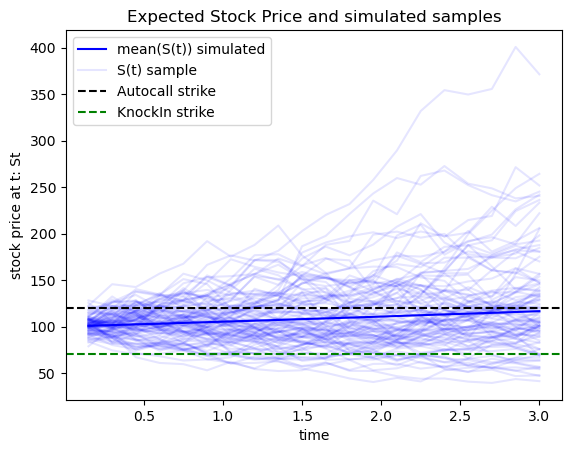

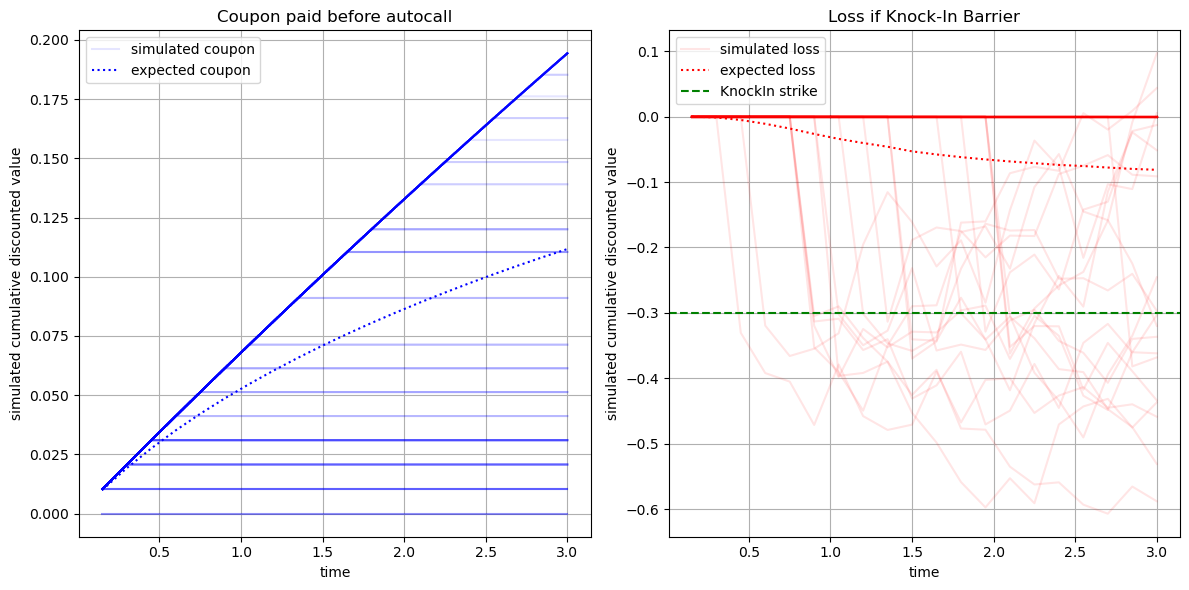

In [17]:
T = 3
coupon = 0.07
AutocallStrike = 120
K  = 100
KI = 70
sigma = 0.25
deltat = T/nT
t = np.linspace(0,T,nT+1)[1:]
np.random.seed(42)
Z = np.random.normal(loc=0, scale=np.sqrt(deltat), size=(nsim//2, nT))
dWt = np.vstack([Z,-Z]) # antithetic variables
Wt  = np.cumsum(dWt,axis=1)
St = S0*np.exp(r*t-.5*sigma**2*t+sigma*Wt)
noautocall = calc_survival_indicator(St>AutocallStrike)
discount = np.exp(-r*t)
coupon   = np.cumsum(coupon*deltat*discount*noautocall,axis=1)
haski    = (1-calc_survival_indicator(St<KI))
loss     = (St-K)/S0*haski*noautocall

plt.plot(t,np.mean(St,axis=0),label="mean(S(t)) simulated",color="blue")
for i in range(100):
    plt.plot(t,St[i,:],color="blue",alpha=0.1,label="S(t) sample" if i==0 else None)
plt.axhline(y=AutocallStrike, color="black", linestyle="--",label="Autocall strike")
plt.axhline(y=KI, color="green", linestyle="--",label="KnockIn strike")
plt.title("Expected Stock Price and simulated samples")
plt.legend()
plt.xlabel("time")
plt.ylabel("stock price at t: St")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(100):
    axs[0].plot(t, coupon[i,:], label="simulated coupon" if i==0 else None, color="blue", alpha=0.1)
axs[0].plot(t, np.mean(coupon, axis=0), label="expected coupon", color="blue", linestyle=":")
axs[0].set_title("Coupon paid before autocall")
axs[0].set_xlabel("time")
axs[0].set_ylabel("simulated cumulative discounted value")
axs[0].grid(True)
axs[0].legend()
for i in range(100):
    axs[1].plot(t, loss[i,:], label="simulated loss" if i==0 else None, color="red", alpha=0.1)
axs[1].plot(t, np.mean(loss, axis=0), label="expected loss", color="red", linestyle=":")
axs[1].axhline(y=KI/S0-1, color="green", linestyle="--",label="KnockIn strike")
axs[1].set_title("Loss if Knock-In Barrier")
axs[1].set_xlabel("time")
axs[1].set_ylabel("simulated cumulative discounted value")
axs[1].grid(True)
axs[1].legend()
plt.tight_layout()
plt.show()
answers["autocall: upside is limited"] = "yes/no" # <- edit
answers["autocall: downside is limited"] = "yes/no" # <- edit
answers["autocall: upside scenarios lead to higher gain than downside ones"] = "yes/no" # <- edit

## **Deep Dive: Knock-Out Probability and the Reflection Principle**


**Why This Matters**:  
The reflection principle bridges probabilistic symmetry with financial applications, enabling exact calculations for barrier-dependent derivatives. It’s a cornerstone of path-dependent option pricing and risk management.

### **1. Setup**
- Let $ B(t) $ be a **standard Brownian motion** (Wiener process) starting at $ B(0) = 0 $.
- Fix a **barrier level** $ a > 0 $.
- Define the **first hitting time** $ \tau_a = \inf \{ t \geq 0 : B(t) = a \} $, the earliest time $ B(t) $ reaches $ a $.

---

### **2. Reflection Principle**
For any $ t > 0 $ and $ x \leq a $, the reflection principle states:
$$
P(B(t) \geq x, \tau_a \leq t) = P(B(t) \geq 2a - x).
$$

**Intuition**:  
- For paths that hit $ a $ before time $ t $, the "mirror image" (reflection) of their trajectory after $ \tau_a $ is equally probable due to the symmetry of Brownian motion.  
- This creates a one-to-one correspondence between paths ending above $ x $ after hitting $ a $ and paths ending above $ 2a - x $.

**Visualization**:  
- Imagine a path hitting $ a $ at $ \tau_a $, then continuing upward or downward with equal likelihood. The reflected path (flipped around $ a $) ensures symmetry in probabilities.

---

### **3. Key Implication: Hitting Probability**
The probability that $ B(t) $ hits $ a $ by time $ t $ is:
$$
P(\tau_a \leq t) = 2 P(B(t) \geq a) = 2 \left(1 - \Phi\left(\frac{a}{\sqrt{t}}\right)\right),
$$
where $ \Phi $ is the standard normal CDF.

**Derivation**:  
1. By the reflection principle, set $ x = a $:  
   $$
   P(B(t) \geq a, \tau_a \leq t) = P(B(t) \geq a).
   $$  
2. Since $ P(B(t) \geq a) $ includes paths that hit $ a $ and those that didn’t, the reflection principle isolates the former:  
   $$
   P(\tau_a \leq t) = 2 P(B(t) \geq a).
   $$

---

### **4. Practical Applications**
- **Barrier Option Pricing**:  
  - Knock-out options expire worthless if the underlying asset hits a barrier. The reflection principle helps compute the probability of this event.  
  - Example: For an up-and-out call, the knockout probability is $ P(\tau_a \leq T) $, where $ a $ is the barrier.  

- **Monte Carlo Enhancements**:  
  - Use the reflection principle to adjust simulated paths that cross barriers, reducing variance in pricing algorithms.  

---

### **5. Limitations and Extensions**
- **Discrete Monitoring**: The reflection principle assumes continuous barrier monitoring. For discrete observations (e.g., daily checks), approximations like the **Broadie-Glasserman correction** are needed.  
- **Drifted Brownian Motion**: If $ B(t) $ has drift $ \mu $ and volatility $\sigma$, the reflection principle can be applied using Girsanov theorem, and the formula generalizes to:  
$P(\tau_a < t) = 1 - \Phi\left(\frac{a - \mu t}{\sigma \sqrt{t}}\right) + e^{\frac{2 \mu a}{\sigma^2}} \Phi\left(\frac{-a - \mu t}{\sigma \sqrt{t}}\right)$





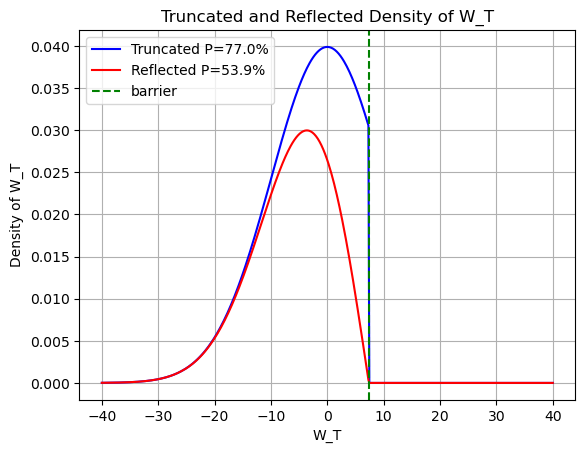

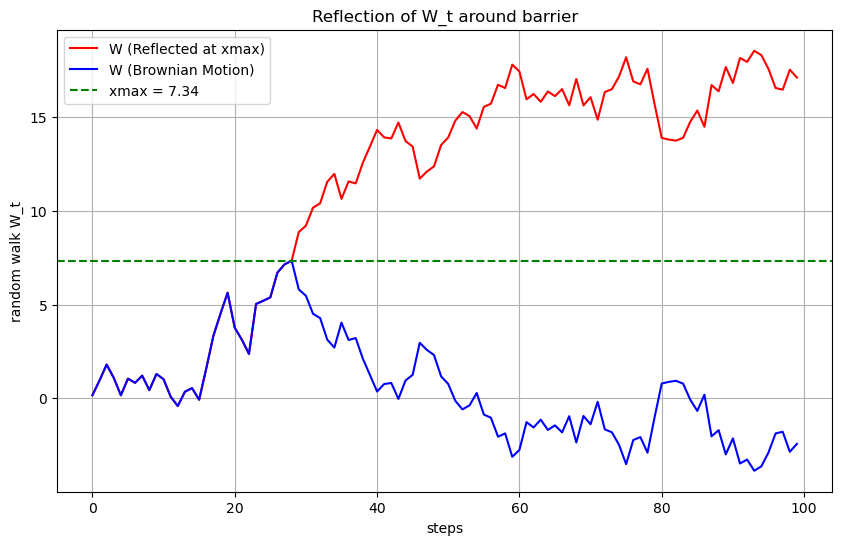

In [18]:
# Generate x as a cumulative sum of normal random variables
np.random.seed(314)
x = np.cumsum(np.random.normal(size=100))
imax = np.argmax(x)
xmax = np.max(x)    # Maximum value of x

# Reflect x around its maximum: y = 2 * xmax - x
y = 2 * xmax - x
y[:imax] = x[:imax]
mean = 0          # Mean of the Brownian motion endpoint
std = np.sqrt(100) # Standard deviation at t=100
xmax = np.max(x)  # Use the same xmax from the path for consistency
n = 500
x_vals = np.linspace(mean - 4 * std, mean + 4 * std, n)
imax = np.argmax(x_vals>xmax)
gaussian_density = si.norm.pdf(x_vals, mean, std)
sumdensity = np.sum(gaussian_density)
truncated_density = gaussian_density.copy()
truncated_density[imax:] = 0  # Set to 0 beyond xmax
reflected_density = gaussian_density.copy()
reflected = -reflected_density[imax:n][::-1]
start = imax-len(reflected)
reflected_density[max(start,0):imax] += reflected[max(-start,0):]
reflected_density[imax:] = 0
plt.plot(x_vals, truncated_density, label='Truncated P=%.1f%%' % (np.sum(truncated_density)/sumdensity*100), color='blue')
plt.plot(x_vals, reflected_density, label='Reflected P=%.1f%%' % (np.sum(reflected_density)/sumdensity*100), color='red')
plt.axvline(x=xmax, color='green', linestyle='--', label='barrier')
plt.xlabel('W_T')
plt.ylabel('Density of W_T')
plt.title('Truncated and Reflected Density of W_T')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()
# Plot x and y
plt.figure(figsize=(10, 6))
plt.plot(y, label='W (Reflected at xmax)', color='red')
plt.plot(x, label='W (Brownian Motion)', color='blue')
plt.axhline(y=xmax, color='green', linestyle='--', label=f'xmax = {xmax:.2f}')
plt.xlabel('steps')
plt.ylabel('random walk W_t')
plt.title('Reflection of W_t around barrier')
plt.legend()
plt.grid(True)
plt.show()
answers["The density in the plot below that corresponds to the above MC simulation is"] = "red/blue" # <- edit
answers["How does taking into account reflexion change KO probability"]        = "increase/decrease/same" # <- edit
answers["How does taking into account reflexion change binary option price"]   = "increase/decrease/same" # <- edit
answers["Improving KO pricing precision can be done using smaller time steps"] = "yes/no" # <- edit



### **Enhancing Precision in Knockout Barrier Option Pricing with Survival Probabilities**

#### **Introduction**
Knockout (KO) barrier options, such as up-and-out calls, are path-dependent derivatives whose payoff depends on whether the underlying asset’s price crosses a predefined barrier during the option’s life. In Monte Carlo simulations, a common approach to pricing these options involves generating sample paths of the underlying asset and using a survival indicator—a binary variable (1 if the path survives the barrier, 0 if it knocks out)—to estimate the option’s expected payoff. However, this method can introduce significant variance due to its discrete nature. An alternative approach, employing survival probabilities rather than indicators, leverages probabilistic estimates of barrier crossing at each time step, offering improved precision. We explore below how this shift enhances the accuracy of pricing KO barrier options, with reference to a typical Monte Carlo implementation.

#### **Survival Indicators in Monte Carlo Simulations**
In a Monte Carlo framework, survival indicators are computed by discretizing the time horizon into $ n_T $ steps and simulating paths of the underlying asset’s log-price, $ \ln(S_t) $, under a risk-neutral measure (e.g., geometric Brownian motion: $ \ln(S_t) = \ln(S_0) + (r - \frac{1}{2}\sigma^2)t + \sigma W_t $). For an up-and-out barrier at $ K_0 $, the survival indicator $ I_{t,i} $ for path $ i $ at time $ t $ is defined as:
- $ I_{t,i} = 1 $ if $ \ln(S_{s,i}) < \ln(K_0) $ for all $ s \leq t $,
- $ I_{t,i} = 0 $ otherwise.

The indicator is typically implemented as shown in the function `calc_survival_indicator`:
- It identifies the first time step where $ \ln(S_t) > \ln(K_0) $ (knockout occurs) and sets $ I_t = 1 $ until that point, then 0 thereafter.
- At maturity $ T $, the terminal indicator $ I_T $ determines whether the path contributes to the payoff (e.g., $ \max(S_T - K, 0) \cdot I_T $ for a call).

While straightforward, this approach has a key limitation: the binary nature of $ I_T $ (0 or 1) introduces high variance, especially near the barrier. Small changes in a path’s trajectory can flip the indicator, leading to a coarse approximation of the true survival probability, particularly in discrete time with limited steps ($ n_T = 50 $ in the example).

#### **Survival Probabilities: A Probabilistic Refinement**
The alternative approach, implemented in `calc_survival_probability`, estimates the probability of surviving the barrier at each time step, rather than relying on a binary outcome. For an up-and-out barrier:
- The standardized distance to the barrier is computed as $ d_t = \frac{\ln(K_0) - \ln(S_t)}{\sigma \sqrt{\Delta t}} $.
- The probability of not hitting the barrier over a single time step $ \Delta t $ is approximated using the reflection principle for Brownian motion: $ P(\text{no hit}) = 1 - 2(1 - N(d_t)) $, capped at 1 to adjust for discrete-time overestimation.
- The cumulative survival probability up to time $ t_k $ is the product across steps: $ P_{r,t_k} = \prod_{i=1}^k P(\text{no hit at } t_i) $.

For an up-and-out option, the knockout probability is then $ 1 - P_{r,t} $. This method uses the continuous distribution of $ W_t $ to estimate the likelihood of crossing $ \ln(K_0) $, rather than relying solely on sampled path crossings.

#### **Improvement in Precision**
Using survival probabilities instead of indicators improves precision in several ways:
1. **Reduced Variance**:
   - The survival indicator $ I_T $ is a Bernoulli random variable with variance $ p(1 - p) $, where $ p $ is the true survival probability. Near the barrier ($ p \approx 0.5 $), this variance is maximized (0.25), amplifying noise in the Monte Carlo estimate.
   - In contrast, the survival probability $ P_{rT} $ is a continuous variable between 0 and 1, reflecting the likelihood of survival based on the path’s position relative to $ \ln(K_0) $. Its variance, as shown in the plot of $ \text{std}[P_{rT} | \ln(S_T)] $, is typically lower than $ \text{std}[I_T | \ln(S_T)] $ near the barrier, smoothing the estimate (see Figure 2 in the code output).

2. **Better Resolution Near the Barrier**:
   - The discrete nature of $ I_T $ means paths just below or above $ \ln(K_0) $ are treated as all-or-nothing (1 or 0), ignoring proximity to the barrier. This is evident in the step-like drop of $ E[I_T | \ln(S_T)] $ at $ \ln(K_0) $ in the binned plot.
   - $ P_{rT} $ captures this proximity through $ d_t $, assigning probabilities close to 0 for paths near or above $ \ln(K_0) $ and higher values for those further below, resulting in a smoother transition in $ E[P_{rT} | \ln(S_T)] $. This aligns more closely with the continuous-time knockout probability.

3. **Convergence with Fewer Paths**:
   - High variance in $ I_T $ requires more simulations ($ n_{\text{sim}} $) to achieve a given precision, as the standard error scales with $ \sqrt{\text{Var}(I_T)} / \sqrt{n_{\text{sim}}} $.
   - Lower variance in $ P_{rT} $ reduces the standard error, enabling faster convergence to the true option price with fewer paths, as the probabilistic estimate averages out noise more effectively.

#### **Illustration with Example Code**
The provided code simulates an up-and-out barrier option ($ S_0 = 100 $, $ K_0 = 140 $, $ T = 1 $, $ n_T = 50 $, $ n_{\text{sim}} = 1000 $) and compares $ I_T $ and $ P_{rT} $:
- **Trajectory Plot**: Shows sample paths of $ \ln(S_t) $ with the barrier at $ \ln(140) $, highlighting path-dependent knockout events.
- **Binned Expectations Plot**: Compares $ E[I_T | \ln(S_T)] $ and $ E[P_{rT} | \ln(S_T)] $ across 20 bins of $ \ln(S_T) $, alongside their standard deviations.
  - $ E[I_T] $ drops sharply from 1 to 0 at $ \ln(K_0) $, with high variance near the barrier.
  - $ E[P_{rT}] $ transitions smoothly, with lower variance, reflecting a more precise estimate of survival likelihood.

#### **Conclusion**
Replacing survival indicators with survival probabilities in Monte Carlo simulations for KO barrier options enhances precision by reducing variance, improving resolution near the barrier, and accelerating convergence. While indicators are simple and intuitive, their binary nature amplifies sampling error in discrete time. Survival probabilities, by incorporating probabilistic barrier-crossing estimates at each step, provide a more nuanced and accurate approximation of the continuous-time knockout dynamics, making them a superior choice for pricing path-dependent options like up-and-out barriers.




check 0.02 0.02


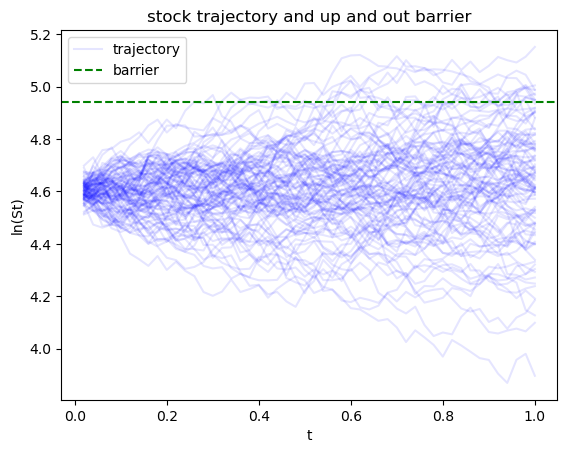

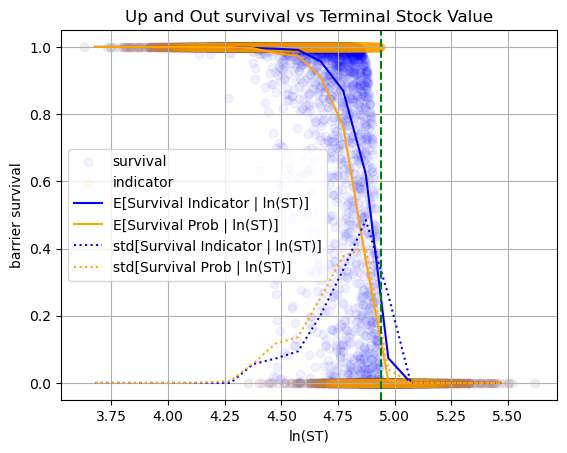

In [19]:
def calc_survival_indicator(kill_condition):
    """Calculate survival indicator: 1 if path is active, 0 if knocked out."""
    first_knockout_idx = np.argmax(kill_condition, axis=1)  # Index of first barrier hit per path
    never_knocked_out = ~np.any(kill_condition, axis=1)     # Paths that never hit barrier
    first_knockout_idx[never_knocked_out] = kill_condition.shape[1]  # Set to nT if no knockout
    time_steps = np.arange(kill_condition.shape[1])[np.newaxis, :]   # Shape (1, nT)
    survival_indicator = (time_steps < first_knockout_idx[:, np.newaxis]).astype(int)  # 1 until knockout
    return survival_indicator

def calc_survival_probability(ln_st, ln_barrier, mu, sigma, delta_t, barrier):
    if barrier[:2]!='up' and barrier[:4]!='down':
        raise Exception("barrier must be up or down unhandled:",barrier)
    m = 1 if barrier[:2]=='up' else -1
    """Calculate probability of surviving (not hitting barrier) up to each time step."""
    distance_to_barrier = m*(ln_barrier - ln_st)/sigma /np.sqrt(delta_t)  # Standardized distance
    prob_not_hit_per_step = 1 - np.minimum(2 * (1 - si.norm.cdf(distance_to_barrier)), 1)  # Survival prob per step
    survival_prob = np.cumproduct(prob_not_hit_per_step, axis=1)  # Cumulative survival probability
    if barrier[-2:]!='in' and barrier[-3:]!='out':
        raise Exception("barrier must be in or out unhandled:",barrier)
    return survival_prob if barrier[-2:]!='out' else 1-survival_prob

# Parameters
T = 1
nsim,nT=10000,50
S0,K0=100,140
r,sigma = 0.05,0.25
deltat = T/nT
t = np.linspace(0,T,nT+1)[1:]
print("check",t[1]-t[0],deltat)
#np.random.seed(42)
Z = np.random.normal(loc=0, scale=np.sqrt(deltat), size=(nsim//2, nT))
dWt = np.vstack([Z,-Z]) # antithetic variables
Wt  = np.cumsum(dWt,axis=1)
lnSt,lnK0 = np.log(S0)+(r-.5*sigma**2)*t+sigma*Wt, np.log(K0)

# Compute survival indicator and probabilities
survival_indicator = calc_survival_indicator(lnSt > lnK0)
survival_probability = calc_survival_probability(lnSt, lnK0, (r-.5*sigma**2), sigma, deltat,"up_and_out")
knockout_probability = 1 - survival_probability  # Probability of knockout

ln_ST, Pr_ST, I_T = lnSt[:,-1],survival_probability[:,-1],survival_indicator[:,-1]
# Bin ln_ST into 20 regular intervals
nbins = 20
bins = np.linspace(ln_ST.min(), ln_ST.max(), nbins + 1)
bin_indices = np.digitize(ln_ST, bins) - 1  # Bin indices (0 to nbins-1)

# Compute conditional expectations
bin_centers = (bins[:-1] + bins[1:]) / 2  # Midpoints of bins
E_IT = np.zeros(nbins)
E_PrST = np.zeros(nbins)
std_IT = np.zeros(nbins)
std_PrST = np.zeros(nbins)
for k in range(nbins):
    in_bin = bin_indices == k
    if np.any(in_bin):
        E_PrST[k] = np.mean(Pr_ST[in_bin])
        E_IT[k]   = np.mean(I_T[in_bin])
        std_PrST[k] = np.std(Pr_ST[in_bin])
        std_IT[k]   = np.std(I_T[in_bin])
    else:
        E_PrST[k]   = np.nan
        E_IT[k]     = np.nan
        std_PrST[k] =  np.nan
        std_IT[k]   =  np.nan
        
for i in range(100):
    plt.plot(t,lnSt[i,:],color="blue",alpha=0.1, label="trajectory" if i==0 else None)
plt.axhline(y=lnK0, color='green', linestyle='--', label='barrier')
plt.legend()
plt.xlabel("t")
plt.ylabel("ln(St)")
plt.title("stock trajectory and up and out barrier")
plt.show()
plt.scatter(ln_ST, Pr_ST,label="survival",alpha=0.05,color="blue")
plt.scatter(ln_ST,I_T,label="indicator",alpha=0.05,color="orange")
plt.plot(bin_centers, E_IT,  label='E[Survival Indicator | ln(ST)]', color="blue")
plt.plot(bin_centers, E_PrST, label='E[Survival Prob | ln(ST)]',color="orange")
plt.plot(bin_centers, std_IT,  label='std[Survival Indicator | ln(ST)]', color="blue",linestyle=":")
plt.plot(bin_centers, std_PrST, label='std[Survival Prob | ln(ST)]',color="orange",linestyle=":")
plt.legend()
plt.xlabel("ln(ST)")
plt.ylabel("barrier survival")
plt.axvline(x=lnK0, color='green', linestyle='--', label='barrier')
plt.grid(True)
plt.title("Up and Out survival vs Terminal Stock Value")
plt.show()
answers["the KO indicator is shown in the graph in"] = "orange/blue" # <- edit
answers["E(Survival|ST) is more accurate for prob or indicator?"]       = "prob/indicator" # <- edit
answers["How is E(Survival|ST) difference expected to change for larger NT"]    = "decrease/increase/same" # <- edit
answers["How is E(Survival|ST) difference expected to change for larger nsim"]  = "decrease/increase/same" # <- edit
answers["std(Survival|ST) is more accurate for prob or indicator"]      = "prob/indicator" # <- edit
answers["How is std(Survival|ST) expected to change with higher NT"]    = "decrease/increase/same" # <- edit
answers["How is std(Survival|ST) expected to change with higher nsim"]  = "decrease/increase/same" # <- edit


In [20]:
# you need to edit this cell to edit MYEMAIL and MYKEY. running this cell will submit your answers
course = "mafs5330"
# import config
# # config.createhash(answers,course)
# MYEMAIL = config.profemail[course]
# MYKEY = config.profapikey[course]
# edit line below when ready to post the answer, http status_code for succesful submission is 200
MYEMAIL  = 'rshao@connect.ust.hk' # <- EDIT email address that received api key from <mail.validation@mg.quantfinance.club>'
MYKEY = '46bb4348b44334e3277327c46999c668bc7db49a02fae092d32348136f5f3ad5'
import requests,json,time
def post_answer(question, answer):
    time.sleep(0.01)
    questionhash = {"PPN: discount factor is": "d570b251e51bdac5fa1fe428336e31f8c0b3ba74d80eee8a55d2a1cdbdeea956", "PPN: call price is": "1e25b356ba6b837189c11c5e83f979febcc8c065b308f24ddd03eaff631809ff", "PPN: PR (assuming no issue cost)": "85da953a1149c9dce33bcc9bcd9dae4fdb0534bc7b8425765fe1a400d500cbb8", "ELN: discount factor is": "95d82170e925a7105d4bdabb78efba06737eb02208ec611d36542ef686b04c30", "ELN: put price is": "96f82fb15b384ef24b6da0ac318f53b8469e8ed5ed1f2af92117bf66bfa85212", "ELN: coupon C (assuming no issue cost)": "7d5a54240203c747bfddae86e9de349d4d5fc1907fbb14ab4e542def9553de36", "antithetic sampling std(WT)": "914d5a31698f439b70660aaaec60e51b4de79cc7f75f689c0b04bc8beafeef3a", "antithetic sampling: avg(S(t=0.35)": "62dc08272e83ef522b1c79e7bbbc1b03121b2f15c07cb4555cd0fe0df4b0b887", "antithetic sampling: E(S(t=0.35)": "a8bde5a0d6d442fbd5c583c3b124b0731b4a95ccbf97fea444c66cd8af8c2e61", "accumulator: most simulations result in positive outcome": "eda2463192e27a0e1b756ee0ee257a3923b43a70d891b6776b22bd767e21b773", "accumulator: negative scenario result in much lower outcome": "30cb70de319af4a251604e57768987983ef234e7af91197fc72b6dfc4d3be8e9", "accumulator: expected pv increase with accumulation strike": "8800d663a43de7c68f3a0ef3d1401a86056600421d2c339d06074d4bdb6bd256", "accumulator: fait buy strike for KO=100 is": "20f0476892610f30ab9a7b9d58d4eb317ecb0a95dd53e42488af6153ef97293b", "having 2x leveraged accumulation below K changes the positive scenarios": "5fb9f398c63185ab9671e4d4ed8a74251d5a8f59b055b48e7b34f6ad0395569b", "having 2x leveraged accumulation makes adverse scenarios x times worse": "ef05ba6f6976b4eb1b98a4841d970369fe2b8c4338241eb5378e424fba3c2032", "having 2x leveraged accumulation leads to a fair strike far below 85": "340faf384f9304e4fb279c914a19f783b5a9bae1e243ca3fde8affd3a14663e7", "having 2x leveraged accumulation leads to a fair strike far above 100": "69f5ebc77da541badd54b966ad3d34045c40a1a916de4ab09c8df04783808b23", "autocall: upside is limited": "a7c529d310488228eeecfdce6121031594028a4b3cf5e3cbcf7ce13f86277975", "autocall: downside is limited": "8d6ca80a7218e353bb3f94226d4c0b8ae0957cb3f8458fdda00538f1c81a46c6", "autocall: upside scenarios lead to higher gain than downside ones": "f16add1f82cc073de82ed45f1ad0b443607c59dafadf61ad96d82ac5e10d7353", "The density in the plot below that corresponds to the above MC simulation is": "8fb8c65bf775f7f29934cfa7b1c182c65da2cfc4d23db979d1eba7eaa9f53406", "How does taking into account reflexion change KO probability": "f3fea9bae2aa9bfb153f31ba476fd0d2324a48ca2b62c2595f0b4937a1f8d171", "How does taking into account reflexion change binary option price": "b006c1b8957d057b822d3e809679a39e094bbc0686ec8934187a205cc129975b", "Improving KO pricing precision can be done using smaller time steps": "54dcc53f295aa9b32d2b176b9c6b2e4d194c68cf1702de79f3984de50f488a2d", "the KO indicator is shown in the graph in": "67d344e608ffbbfefc6c61e3fdfa11f53e9501ec6ee53e5f7f8e064933cdd7ef", "E(Survival|ST) is more accurate for prob or indicator?": "07b07f725e320fff7a6bd03e28800c4dda617c2ba2e67865300f83212ae90fc2", "How is E(Survival|ST) difference expected to change for larger NT": "980ea03d54ff5efacce4b98ee48af1e818988eb3441573318adb9ad4df4be19a", "How is E(Survival|ST) difference expected to change for larger nsim": "6d92656736b4a5efc9fe72c72d867fe5d161b54749f8c644c0596adc00ebd8e7", "std(Survival|ST) is more accurate for prob or indicator": "aa45636b802250fae53d8f91ca0387a37362d9fd84540bb087c078c2d423f375", "How is std(Survival|ST) expected to change with higher NT": "adb25f797a25986f72fa548680bc47935bf754fccb0222a4311eea456dbb4630", "How is std(Survival|ST) expected to change with higher nsim": "592e203139a0cfcc1ef8427681c08c553fd51673d7b6227a48db7049a049162e"}
    return requests.post(f"https://www.quantfinance.club/{course}",data={'user':MYEMAIL,'mykey':MYKEY,'questionid':question,'answer':answer,'questionkey':questionhash[question]})
nbAnswers = 31
if len(answers)!=nbAnswers:
    raise Exception(f"There are {len(answers)} answers, should be {nbAnswers}. You can comment this check if you want to submit partial answers.")
for q,a in answers.items():
    x = post_answer(q, a)
    if x.status_code!=200:
        if x.status_code==401:
            raise Exception("API Key Authentication failed: please make sure the variables MYEMAIL and MYKEY are set")
        raise Exception("submission error with code:",x.status_code)
    else:
        print("submitted answer to %s=%s" % (q,str(a)))
print(f"check your latest submitted answers on:\nhttps://www.quantfinance.club/{course}_myanswers?email={MYEMAIL}&apikey={MYKEY}")


submitted answer to PPN: discount factor is=0.951229424500714
submitted answer to PPN: call price is=0.10450583572185565
submitted answer to PPN: PR (assuming no issue cost)=0.46667801049014945
submitted answer to ELN: discount factor is=0.9753099120283326
submitted answer to ELN: put price is=0.00012407926560673854
submitted answer to ELN: coupon C (assuming no issue cost)=0
submitted answer to antithetic sampling std(WT)=0.5191030396598639
submitted answer to antithetic sampling: avg(S(t=0.35)=102.38670043782646
submitted answer to antithetic sampling: E(S(t=0.35)=100
submitted answer to accumulator: most simulations result in positive outcome=yes
submitted answer to accumulator: negative scenario result in much lower outcome=yes
submitted answer to accumulator: expected pv increase with accumulation strike=yes/no
submitted answer to accumulator: fait buy strike for KO=100 is=110
submitted answer to having 2x leveraged accumulation below K changes the positive scenarios=yes/no
submit